# Produce $\pi$ acceptance maps using GEMC simulation results

last edit Feb-10, 2021

## Imports and definitions

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import sys; sys.path.insert(0, '/Users/erezcohen/Desktop/Software/mySoftware/Python/'); 
from my_tools               import *; 
from plot_tools             import *;
from my_data_analysis_tools import *;
%config InlineBackend.figure_format = 'retina'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
r2d = 180./np.pi

In [2]:
import matplotlib as mpl
cmap = mpl.cm.hot

In [3]:
main_data_path     = '/Users/erezcohen/Desktop/data/BAND/AcceptanceCorrection/GEMCimulationOuputFiles/'

In [4]:
pi_charge_names  = ['piplus'   ,'piminus'  ]
pi_labels        = ['\pi^{+}'  ,'\pi^{-}'  ]
pi_colors        = ['royalblue','salmon'   ]

In [5]:
p_min     = 1.25 # GeV/c
p_max     = 5.00 # GeV/c
theta_min = 3    # deg.
theta_max = 40   # deg.
phi_min   = -180 # deg.
phi_max   = 180  # deg.
delta_Vz_resolution = 0.5; # 1\sigma = 5 mm momentum resolution for CLAS

## Auxiliary

## load data

In [9]:
eepi_GEMC = pd.read_csv( main_data_path + 'eepips_p_uniform_distribution.csv')
Nevents      = len(eepi_GEMC)
Nevents_pips = len(eepi_GEMC[eepi_GEMC.Npips>0])
print('%.1f'%(100.*Nevents_pips /Nevents),'% of the ','%d events include pi+'%Nevents)

65.3 % of the  50013 events include pi+


## plots

#### 1D acceptance maps in $p,\theta,\phi$

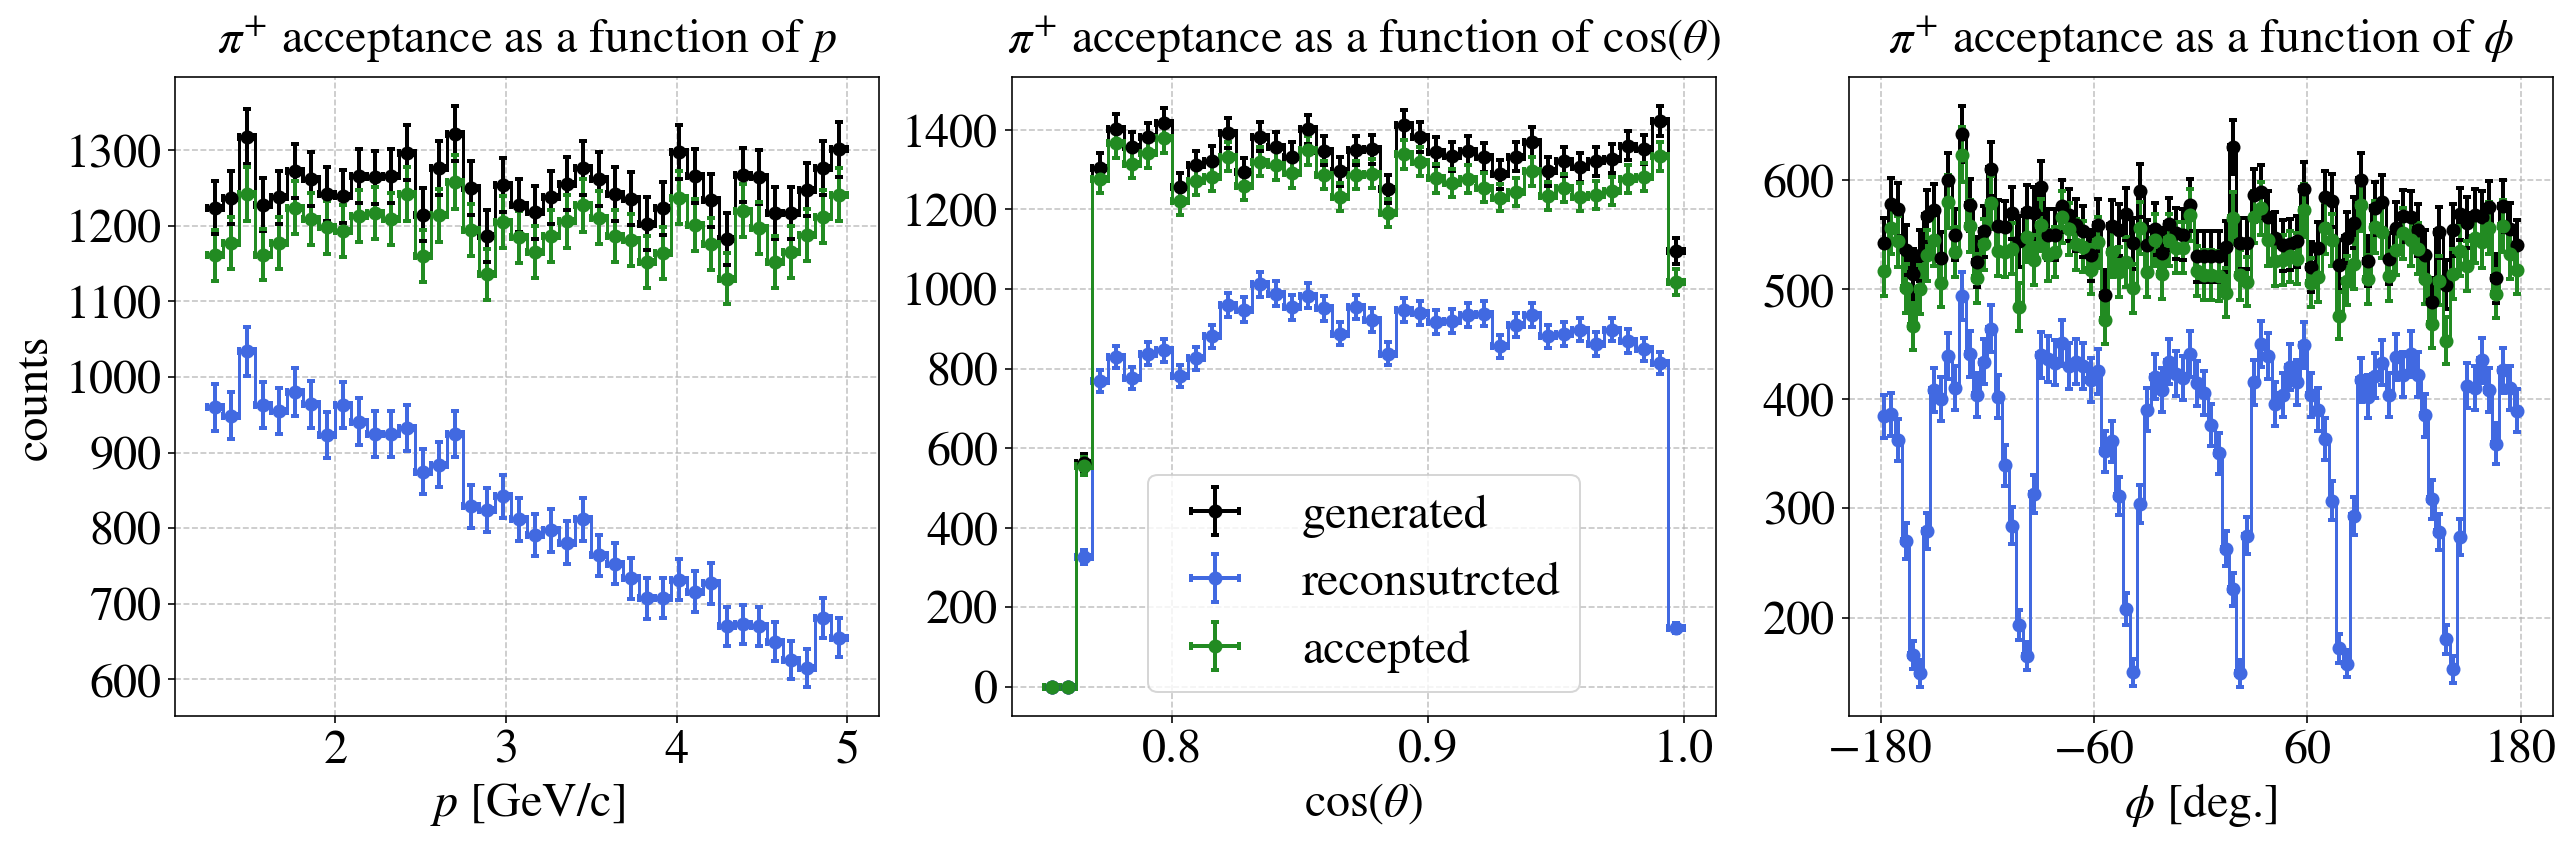

In [13]:
fig = plt.figure(figsize=(18,6))
for (var_gen,
     label,units,bins,
     scale_factor,xticks,
     function,
     subplot_idx) in zip(['pi_P_g','pi_Theta_g','pi_Phi_g'],
                         ['$p$','$\cos(\\theta)$', '$\phi$'], 
                         ['[GeV/c]','', '[deg.]'], 
                         [np.linspace(p_min, p_max,41),
                          np.linspace(0.75,1,41),
                          np.linspace(phi_min, phi_max,91)],
                         [1,r2d,r2d],
                         [[2,3,4,5],[0.8,0.9,1],[-180,-60,60,180]],
                         ['','cos',''],                         
                         range(3)):

    df_gen = eepi_GEMC;
    df_rec = eepi_GEMC[eepi_GEMC.pi_reconstructed==1];
    df_acc = eepi_GEMC[eepi_GEMC.pi_passed_cuts  ==1];    
    x_gen = df_gen[var_gen]
    x_rec = df_rec[var_gen]    
    x_acc = df_acc[var_gen]    
    

                                      
    ax = fig.add_subplot(1,3,subplot_idx+1)
    if function=='cos':
        
        plot_step_hist( np.cos(x_gen), bins, color='k',           label='generated')
        plot_step_hist( np.cos(x_rec), bins, color='royalblue',   label='reconsutrcted')    
        plot_step_hist( np.cos(x_acc), bins, color='forestgreen', label='accepted')    

    else:
        plot_step_hist( x_gen*scale_factor, bins, color='k',           label='generated')
        plot_step_hist( x_rec*scale_factor, bins, color='royalblue',   label='reconsutrcted')
        plot_step_hist( x_acc*scale_factor, bins, color='forestgreen', label='accepted')            
        
    # ax.set_yscale('log')
    set_axes(ax,label + ' ' + units,'counts' if subplot_idx==0 else '',
             do_add_legend=True if subplot_idx==1 else False,
             title='$\pi^{+}$ acceptance as a function of '+label, fontsize=24, do_add_grid=True,xticks=xticks)
plt.tight_layout();

In [11]:
eepi_GEMC

,e_P,e_Theta,e_Phi,e_Vz,pi_P,pi_Theta,pi_Phi,pi_Vz,Npips,Npims,...,e_Theta_g,e_Phi_g,e_Vz_g,pi_P_g,pi_Theta_g,pi_Phi_g,pi_Vz_g,pi_reconstructed,pi_passed_cuts,Unnamed: 25
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000,0.0,0.0,NaN
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000,0.0,0.0,NaN
2,1.338906,0.543550,-2.854447,8.065559,2.576770,0.540074,-0.190690,7.131353,1.0,0.0,...,0.539309,-2.851868,7.758,2.588723,0.541613,-0.188124,7.624,1.0,1.0,NaN
3,1.287269,0.542727,-2.844619,7.884735,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.539309,-2.851868,7.758,3.369837,0.173128,2.825922,8.646,0.0,1.0,NaN
4,1.328159,0.529179,-2.843025,8.545262,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.539309,-2.851868,7.758,4.196365,0.187125,-2.688738,7.680,0.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50008,1.350654,0.539091,-2.850051,7.391558,2.674612,0.623698,2.045332,8.077494,1.0,0.0,...,0.539309,-2.851868,7.758,2.671480,0.623175,2.045129,8.609,1.0,1.0,NaN
50009,1.337640,0.546240,-2.858024,8.656198,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.539309,-2.851868,7.758,3.156756,0.416990,-2.522011,7.583,0.0,1.0,NaN
50010,1.494325,0.071236,3.059009,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.539309,-2.851868,7.758,2.127734,0.082656,2.534406,8.237,0.0,1.0,NaN
50011,1.336347,0.529818,-2.844241,8.014655,4.558459,0.567880,-3.008716,7.547535,1.0,0.0,...,0.539309,-2.851868,7.758,4.601629,0.567501,-3.008040,7.638,1.0,1.0,NaN


#### The distibution of $z$-vertex difference

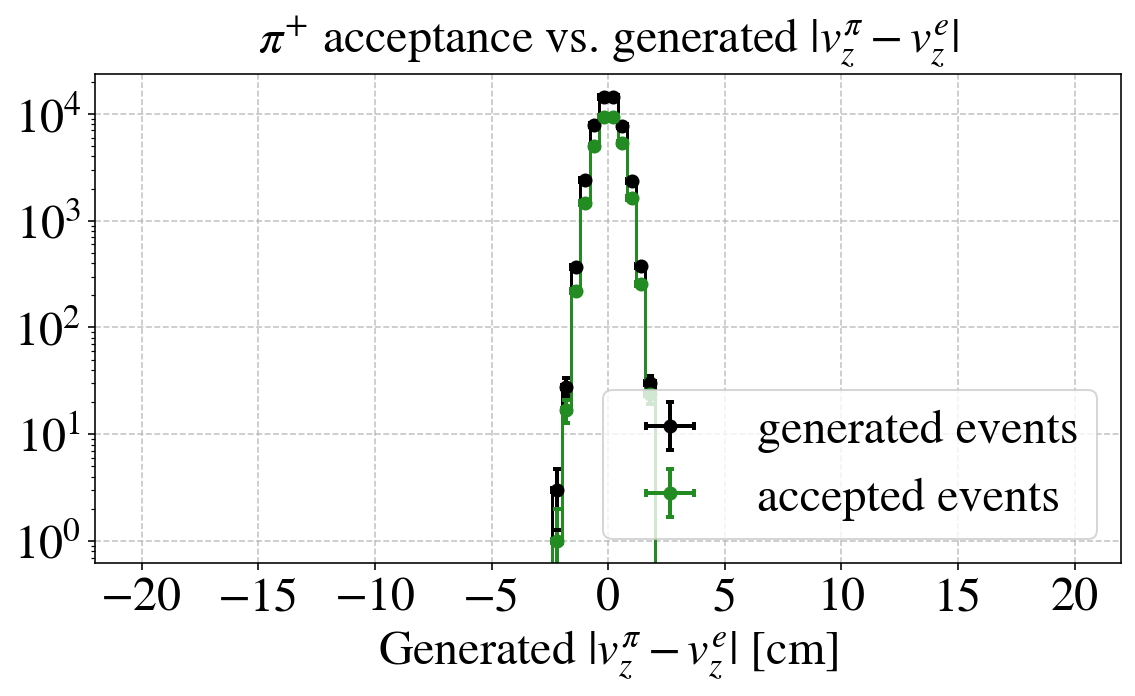

In [199]:
fig = plt.figure(figsize=(8,5))
label = '$|v_z^{\pi}-v_z^{e}|$'
units = '[cm]'
bins = np.linspace(-20,20,101)
df_gen = eepi_GEMC;
df_acc = eepi_GEMC[eepi_GEMC.Npips>0];
                                      
ax = fig.add_subplot(1,1,1)
x_gen = df_gen['pi_Vz_g'] - df_gen['e_Vz_g']
x_acc = df_acc['pi_Vz_g'] - df_acc['e_Vz_g']
plot_step_hist( x_gen, bins, color='k', label='generated events')
plot_step_hist( x_acc, bins, color='forestgreen', label='accepted events')    
ax.set_yscale('log')
set_axes(ax,'Generated '+label + ' ' + units,'counts' if subplot_idx==0 else '',
         do_add_legend=True ,
         title='$\pi^{+}$ acceptance vs. generated '+label, fontsize=24, do_add_grid=True);

# a plot of reconsutrcted pion vertex for events in which a pion is not reconstructed - makes no sense
# ax = fig.add_subplot(1,2,2)
# x_gen = df_gen['pi_Vz'] - df_gen['e_Vz']
# x_acc = df_acc['pi_Vz'] - df_acc['e_Vz']
# plot_step_hist( x_gen, bins, color='k', label='generated events')
# plot_step_hist( x_acc, bins, color='forestgreen', label='accepted events')    
# ax.set_yscale('log')
# set_axes(ax,'Reconstructed '+label + ' ' + units,'counts' if subplot_idx==0 else '',
#          do_add_legend=False,
#          title='$\pi^{+}$ acceptance vs. reconstructed '+label, fontsize=24, do_add_grid=True);

plt.tight_layout()

#### 2D acceptance maps in $p -\theta$ and $\theta-\phi$

#### create maps

In [147]:
# ## p vs. theta
# x_var_g, xlabel, xunits = 'pi_P_g', '$p$','[GeV/c]'
# y_var_g, ylabel, yunits = 'pi_Theta_g', '$\\theta$','[deg.]'
# bins = (np.linspace(p_min, p_max,5),np.linspace(theta_min, theta_max,5))

# x_gen,x_acc = df_gen[x_var_g],     df_acc[x_var_g]    
# y_gen,y_acc = df_gen[y_var_g]*r2d, df_acc[y_var_g]*r2d   
# h_gen, xedges, yedges = np.histogram2d( x_gen , y_gen , bins=bins )
# h_acc, xedges, yedges = np.histogram2d( x_acc , y_acc , bins=bins )

# h_eff = np.ones([len(xedges)-1,len(yedges)-1])
# for i in range(len(xedges)-1):
#     for j in range(len(yedges)-1):
#         h_eff[i][j] = 100.*float(h_acc[i][j])/np.max([1,h_gen[i][j]])

# print('Done producing acceptance maps')
# h_acc

In [201]:
## p vs. theta
x_var_g, xlabel, xunits = 'pi_P_g', '$p$','[GeV/c]'
y_var_g, ylabel, yunits = 'pi_Theta_g', '$\cos(\\theta)$',''
# note the inverted order: y then x
# [https://numpy.org/doc/stable/reference/generated/numpy.histogram2d.html]
# Histogram does not follow Cartesian convention (see Notes), 
# therefore transpose H for visualization purposes.
bins = (np.linspace(0.75, 1,31),np.linspace(p_min, p_max,31))

x_gen,x_acc = df_gen[x_var_g],     df_acc[x_var_g]    
y_gen,y_acc = np.cos(df_gen[y_var_g]), np.cos(df_acc[y_var_g])
h_gen, yedges, xedges = np.histogram2d( y_gen , x_gen , bins=bins )
h_acc, yedges, xedges = np.histogram2d( y_acc , x_acc , bins=bins )

h_eff = np.ones([len(xedges)-1,len(yedges)-1])
for i in range(len(xedges)-1):
    for j in range(len(yedges)-1):
        h_eff[i][j] = 100.*float(h_acc[i][j])/np.max([1,h_gen[i][j]])

print('Done producing acceptance maps')
# h_acc

Done producing acceptance maps


#### plot maps

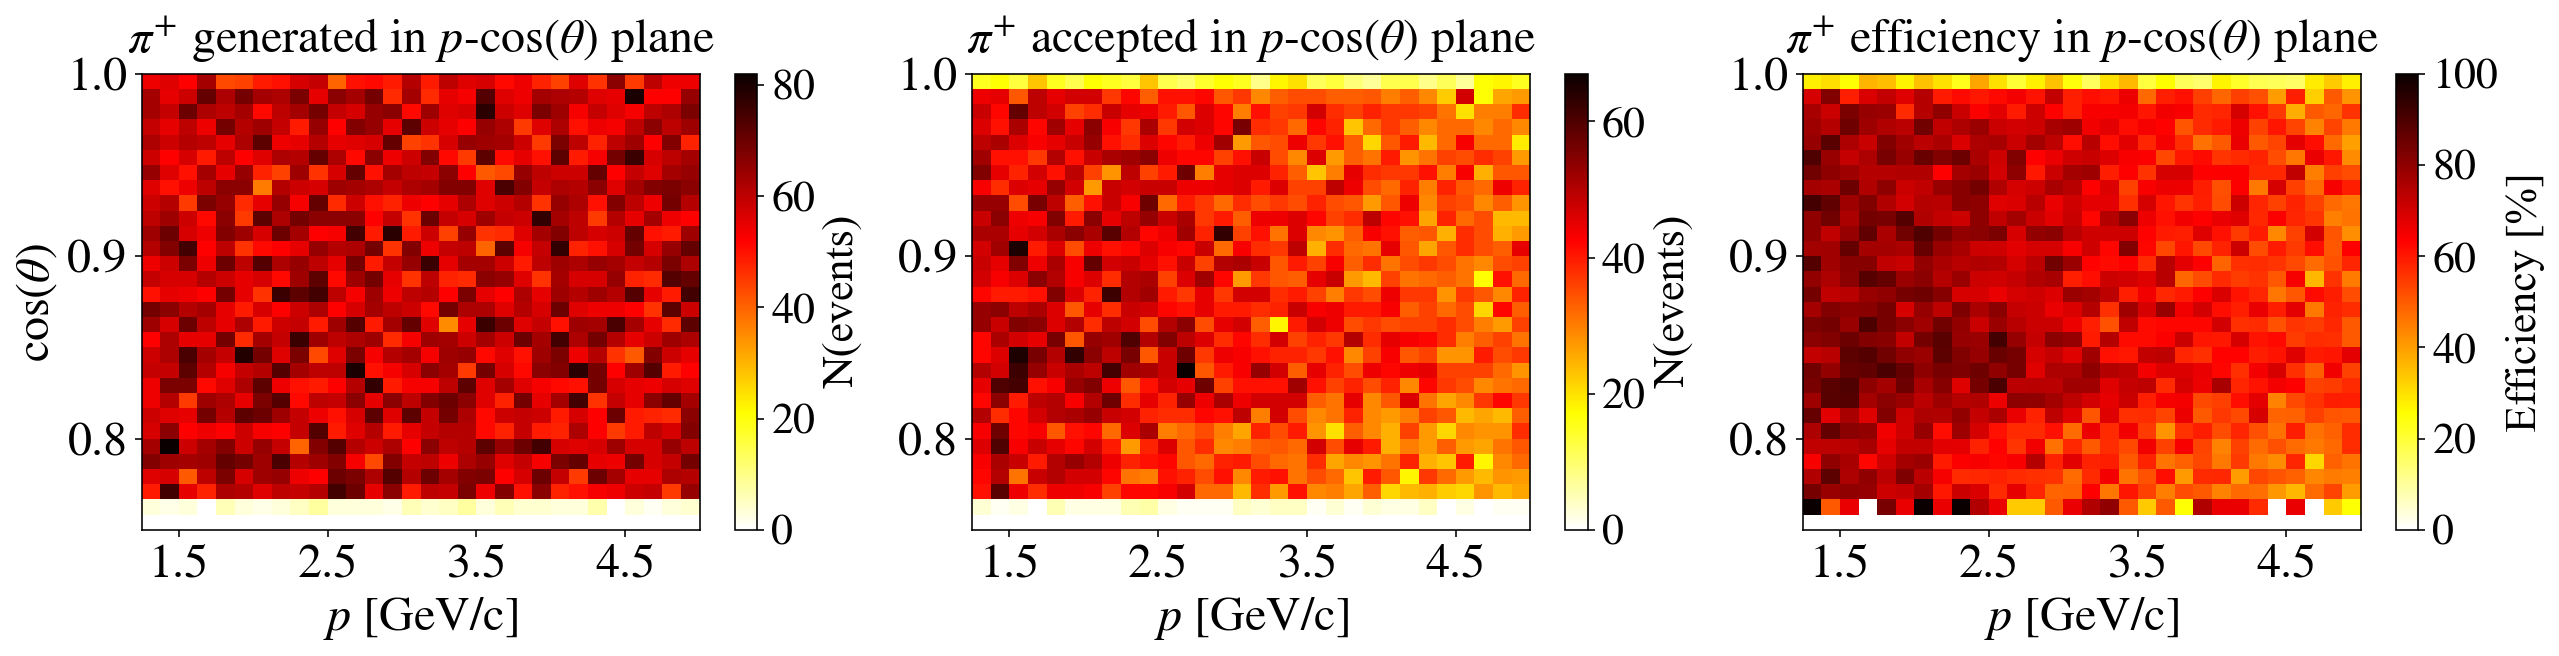

In [202]:
xticks = [1.5,2.5,3.5,4.5]
yticks = [0.8,0.9,1]
extent=[p_min,p_max,theta_min,theta_max]

fig = plt.figure(figsize=(18,8))
for h,hlabel,cbarunits,subplot_idx in zip([h_gen,h_acc,h_eff],
                                          ['generated','accepted','efficiency'],
                                          ['N(events)','N(events)','Efficiency [%]'],
                                          [1,2,3]):
    ax = fig.add_subplot(2,3,subplot_idx)
    im = ax.pcolormesh(xedges, yedges, h, cmap='hot_r')
    # colorbar
    cbar = plt.colorbar( im, label=cbarunits )    
    cbar.ax.tick_params(labelsize=22)
    cbar.ax.yaxis.label.set_font_properties(mpl.font_manager.FontProperties(family='times new roman', size=22))
    # cosmetics
    set_axes(ax, xlabel + ' ' + xunits,ylabel + ' ' + yunits if subplot_idx==1 else '',
                 title='$\pi^{+}$ '+hlabel+' in '+xlabel+'-'+ylabel+' plane',
             fontsize=24, do_add_grid=False,xticks=xticks,yticks=yticks)
    
plt.tight_layout();

In [203]:
## theta vs. \phi
x_var_g, xlabel, xunits = 'pi_Theta_g', '$\cos(\\theta)$',''
y_var_g, ylabel, yunits = 'pi_Phi_g', '$\phi$','[deg.]'
# note the inverted order: y then x
# [https://numpy.org/doc/stable/reference/generated/numpy.histogram2d.html]
# Histogram does not follow Cartesian convention (see Notes), 
# therefore transpose H for visualization purposes.
bins = (np.linspace(phi_min, phi_max,31),np.linspace(0.75, 1,31))

x_gen,x_acc = np.cos(df_gen[x_var_g]), np.cos(df_acc[x_var_g])
y_gen,y_acc = df_gen[y_var_g]*r2d, df_acc[y_var_g]*r2d   
h_gen, yedges, xedges = np.histogram2d( y_gen , x_gen , bins=bins )
h_acc, yedges, xedges = np.histogram2d( y_acc , x_acc , bins=bins )

h_eff = np.ones([len(xedges)-1,len(yedges)-1])
for i in range(len(xedges)-1):
    for j in range(len(yedges)-1):
        h_eff[i][j] = 100.*float(h_acc[i][j])/np.max([1,h_gen[i][j]])

print('Done producing acceptance maps')
# h_acc

Done producing acceptance maps


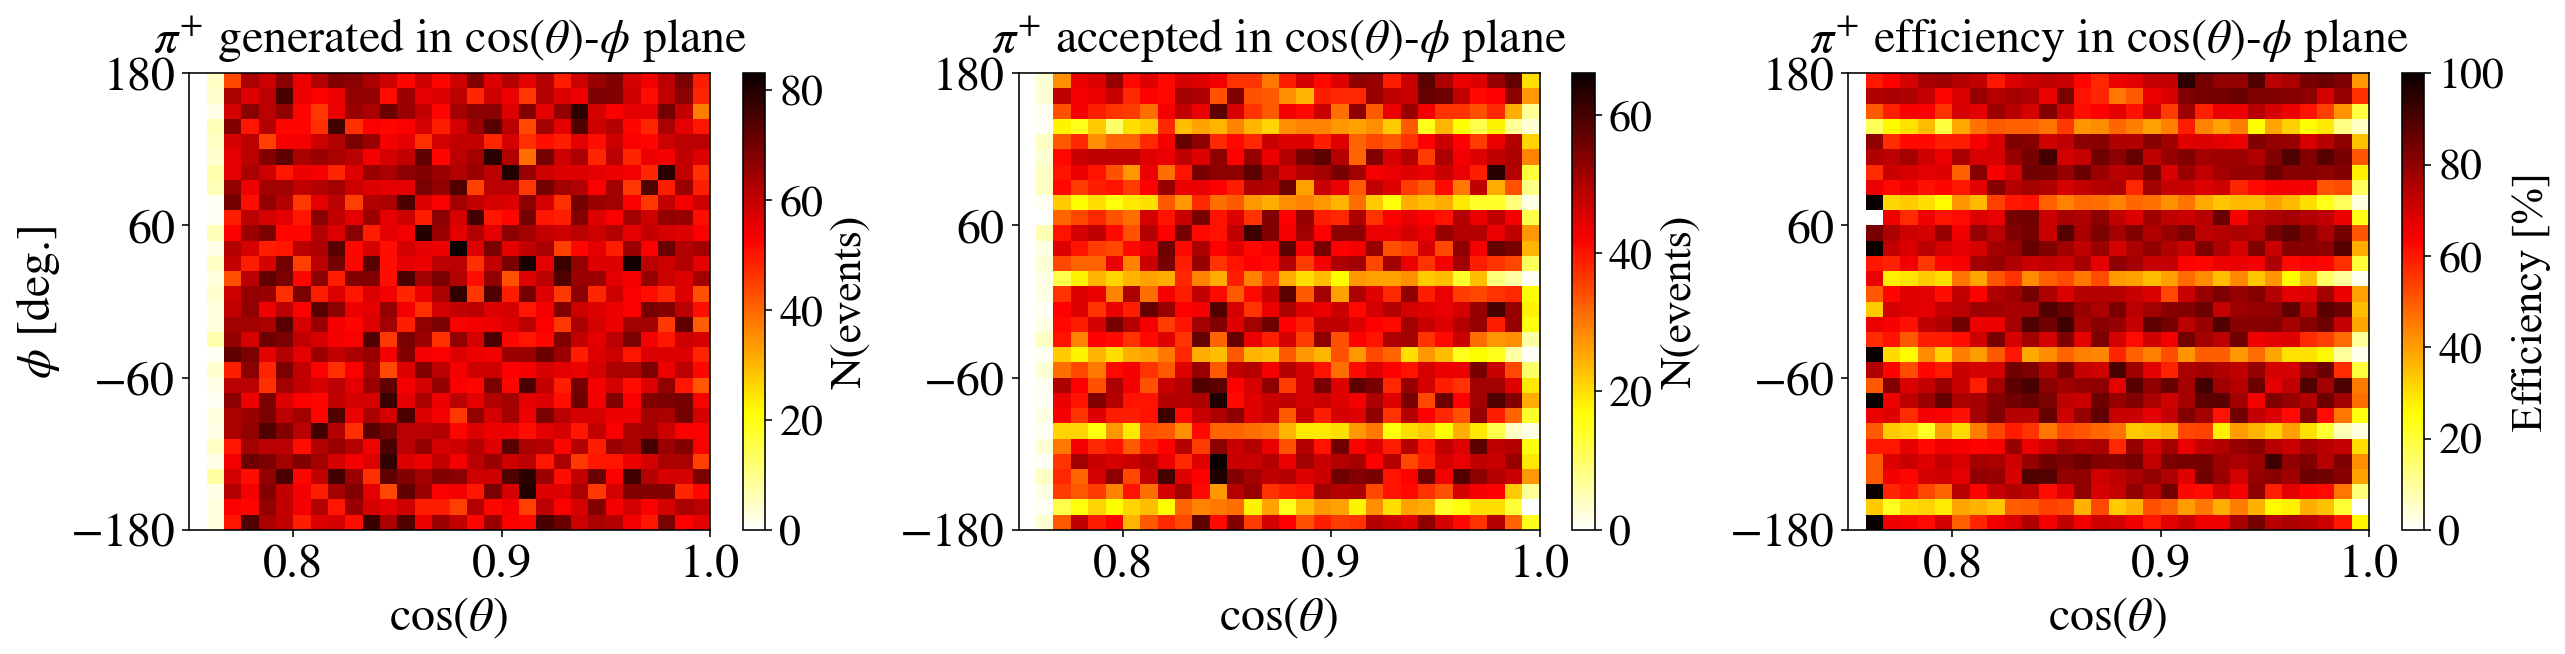

In [204]:
xticks = [0.8,0.9,1]
yticks = [-180,-60,60,180]

extent=[p_min,p_max,theta_min,theta_max]

fig = plt.figure(figsize=(18,8))
for h,hlabel,cbarunits,subplot_idx in zip([h_gen,h_acc,h_eff],
                                          ['generated','accepted','efficiency'],
                                          ['N(events)','N(events)','Efficiency [%]'],
                                          [1,2,3]):
    ax = fig.add_subplot(2,3,subplot_idx)
    im = ax.pcolormesh(xedges, yedges, h, cmap='hot_r')
    # colorbar
    cbar = plt.colorbar( im, label=cbarunits )    
    cbar.ax.tick_params(labelsize=22)
    cbar.ax.yaxis.label.set_font_properties(mpl.font_manager.FontProperties(family='times new roman', size=22))
    # cosmetics
    set_axes(ax, xlabel + ' ' + xunits,ylabel + ' ' + yunits if subplot_idx==1 else '',
                 title='$\pi^{+}$ '+hlabel+' in '+xlabel+'-'+ylabel+' plane',
             fontsize=24, do_add_grid=False,xticks=xticks,yticks=yticks)
    
plt.tight_layout();

In [205]:
## p vs. \phi
x_var_g, xlabel, xunits = 'pi_P_g', '$p$','[GeV/c]'
y_var_g, ylabel, yunits = 'pi_Phi_g', '$\phi$','[deg.]'
# note the inverted order: y then x
# [https://numpy.org/doc/stable/reference/generated/numpy.histogram2d.html]
# Histogram does not follow Cartesian convention (see Notes), 
# therefore transpose H for visualization purposes.
bins = (np.linspace(phi_min, phi_max,31),np.linspace(p_min, p_max,31))

x_gen,x_acc = df_gen[x_var_g], df_acc[x_var_g]
y_gen,y_acc = df_gen[y_var_g]*r2d, df_acc[y_var_g]*r2d   
h_gen, yedges, xedges = np.histogram2d( y_gen , x_gen , bins=bins )
h_acc, yedges, xedges = np.histogram2d( y_acc , x_acc , bins=bins )

h_eff = np.ones([len(xedges)-1,len(yedges)-1])
for i in range(len(xedges)-1):
    for j in range(len(yedges)-1):
        h_eff[i][j] = 100.*float(h_acc[i][j])/np.max([1,h_gen[i][j]])

print('Done producing acceptance maps')

Done producing acceptance maps


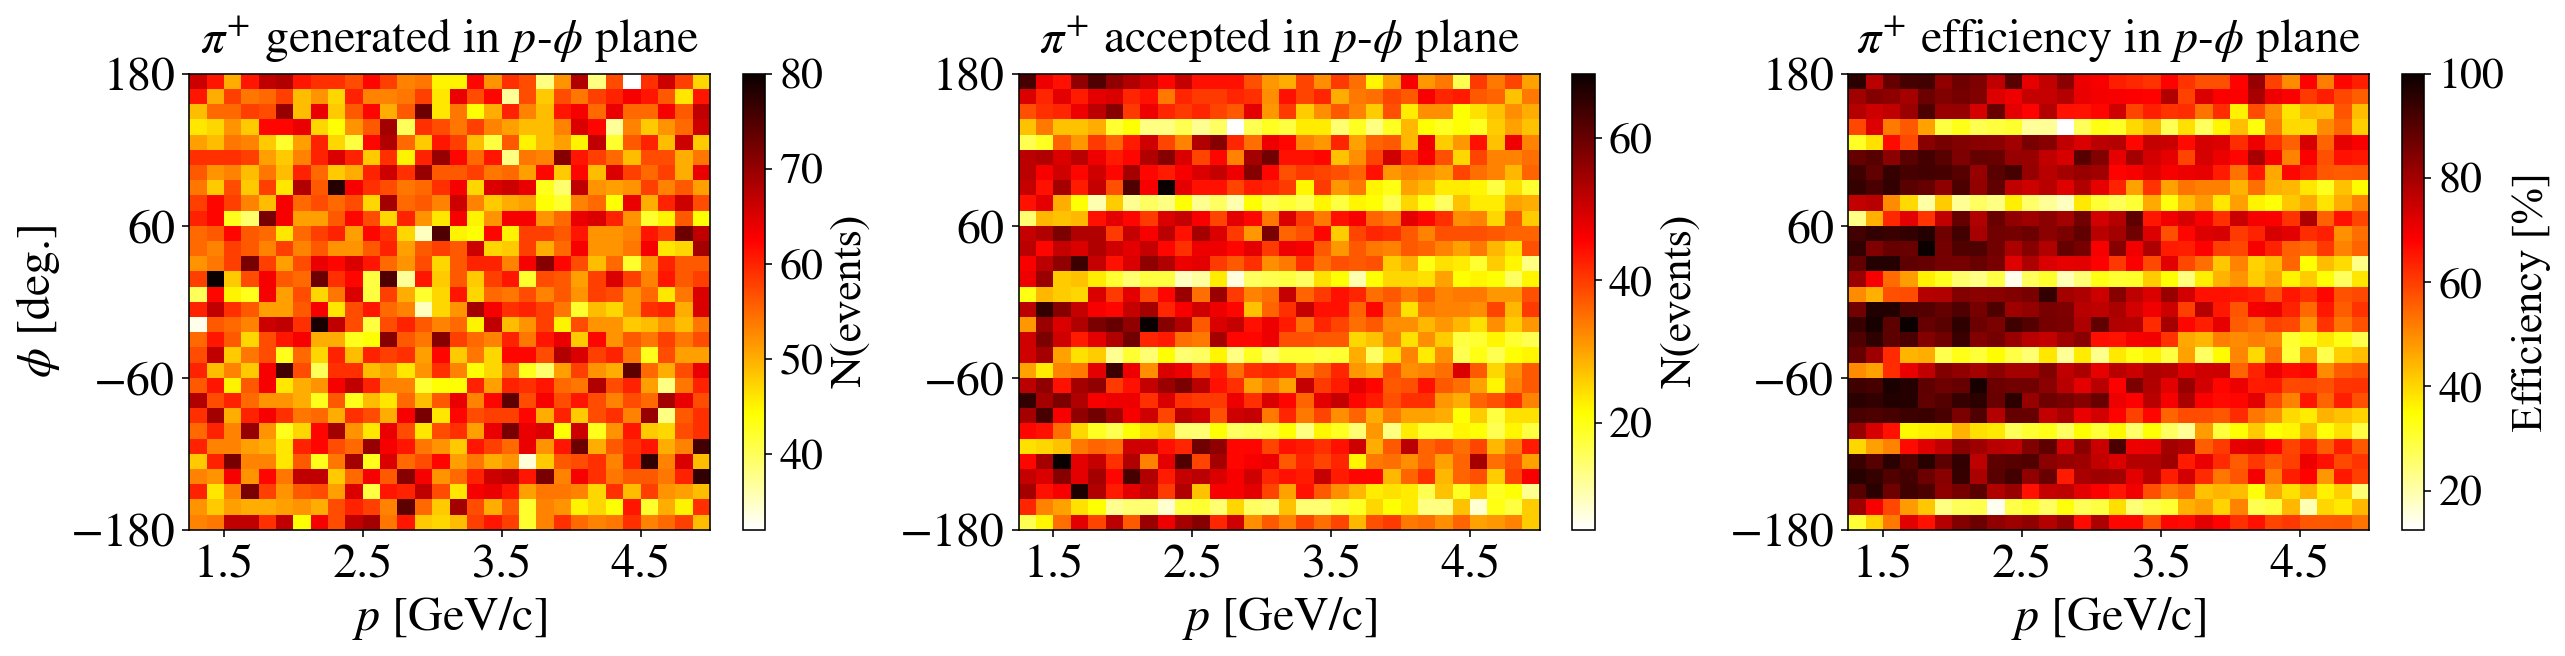

In [206]:
xticks = [1.5,2.5,3.5,4.5]
yticks = [-180,-60,60,180]

extent=[p_min,p_max,theta_min,theta_max]

fig = plt.figure(figsize=(18,8))
for h,hlabel,cbarunits,subplot_idx in zip([h_gen,h_acc,h_eff],
                                          ['generated','accepted','efficiency'],
                                          ['N(events)','N(events)','Efficiency [%]'],
                                          [1,2,3]):
    ax = fig.add_subplot(2,3,subplot_idx)
    im = ax.pcolormesh(xedges, yedges, h, cmap='hot_r')
    # colorbar
    cbar = plt.colorbar( im, label=cbarunits )    
    cbar.ax.tick_params(labelsize=22)
    cbar.ax.yaxis.label.set_font_properties(mpl.font_manager.FontProperties(family='times new roman', size=22))
    # cosmetics
    set_axes(ax, xlabel + ' ' + xunits,ylabel + ' ' + yunits if subplot_idx==1 else '',
                 title='$\pi^{+}$ '+hlabel+' in '+xlabel+'-'+ylabel+' plane',
             fontsize=24, do_add_grid=False,xticks=xticks,yticks=yticks)
    
plt.tight_layout();